# Train With Colbert

In [2]:
import os
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Optional, Union
from scipy.special import softmax
from pathlib import Path

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
from colbert import Indexer, Searcher

import wandb
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments, IntervalStrategy, get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from datasets import Dataset # HuggingFace
from torch.optim import AdamW

In [3]:
pl.Config(fmt_str_lengths=2000);

In [4]:
#!conda install -c conda-forge faiss-gpu -y

In [5]:
dfs = []
folder_path = './data/daniel_train/aug_30/*'
columns = ['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4', 'title', 'section_title']

for csv_file in glob.glob(folder_path):
    df = pl.read_csv(csv_file)
    dfs.append(df[columns])

train_raw = pl.concat(dfs)
train_raw.shape

(2150, 8)

In [6]:
choices_np = train_raw[['correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4']].to_numpy()

n_rows, n_cols = choices_np.shape
shuffled_indices = np.array([np.random.permutation(n_cols) for _ in range(n_rows)])
shuffled_data = np.take_along_axis(choices_np, shuffled_indices, axis=1)
correct_positions = np.argmax(shuffled_data == choices_np[:, 0][:, np.newaxis], axis=1)

answer_map = np.array(['A', 'B', 'C', 'D', 'E'])
answers = answer_map[correct_positions]

choices = pl.DataFrame({
    'A': shuffled_data[:, 0].astype(str),
    'B': shuffled_data[:, 1].astype(str),
    'C': shuffled_data[:, 2].astype(str),
    'D': shuffled_data[:, 3].astype(str),
    'E': shuffled_data[:, 4].astype(str),
    'answer': answers
    },
    [(col, pl.Utf8) for col in ['A', 'B', 'C', 'D', 'E', 'answer']]
)

train = train_raw[['question','title', 'section_title']].with_columns(choices)
train.columns

['question', 'title', 'section_title', 'A', 'B', 'C', 'D', 'E', 'answer']

In [7]:
test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")
test.columns

['question', 'A', 'B', 'C', 'D', 'E', 'answer']

## Retrieve Wiki Context via ColBERT

In [8]:
max_words = 70
wiki_passages = pl.read_parquet('./data/wiki_passages_{max_words}.parquet')
wiki_passages.columns

['passage_id', 'section_id', 'title', 'section_title', 'passage_text']

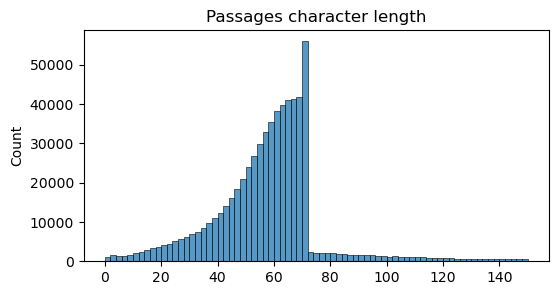

In [31]:
plt.figure(figsize=[6,3])
sns.histplot(wiki_passages['passage_text'].str.split(' ').list.lengths(), binrange=[0, 150], bins=75)
plt.title('Passages character length');

In [9]:
n_results_per_question = 3

nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 512   # lenght in tokens
dim = 128 # 128 is max for BERT

wiki_passages = pl.read_parquet('./data/wiki_passages_{max_words}.parquet')
wiki_passages.columns

checkpoint = './checkpoints/colbertv2.0'
experiment = 'wiki-science'
indexer_name = f"wiki_pages_index_{nbits}bits_max_words{max_words}"
#os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    nbits=nbits,
    dim=dim
)

In [10]:
wiki_passages['passage_text']

passage_text
str
"""In quantum field theory, the 't Hooft loop is a magnetic analogue of the Wilson loop for which spatial loops give rise to thin loops of magnetic flux associated with quantum vortex. They play the role of a order parameter for the Higgs phase in pure gauge theory."""
"""Consistency conditions between electric charge and magnetic charges limit the possible 't Hooft loops that can be used, similarly to the way that the Dirac quantization condition limits the set of allowed magnetic monopole. They were first introduced by Gerard 't Hooft in 1978 in the context of possible phase (matter) that gauge theories admit."""
"""There are a number of ways to define 't Hooft lines and loops. For causal structure curves C they are equivalent to the gauge configuration arising from the world line traced out by a magnetic monopole."""
"""These are singularity (mathematics) gauge field configurations on the line such that their spatial slice have a magnetic field whose form approaches that of a magnetic monopole Bi xrightarrowrrightarrow 0 fracxi4pi r3Q(x), where in Yang–Mills theory Q(x) is the generally Lie algebra valued object"""
"""specifying the magnetic charge. 't Hooft lines can also be inserted in the path integral formulation by requiring that the gauge field measure can only run over configurations whose magnetic field takes the above form. More generally, the 't Hooft loop can be defined as the operator (physics)"""
"""whose effect is equivalent to performing a modified gauge transformations Omega that is singular on the loop C in such a way that any other loop C' parametrized by s in [0,1] with a winding number l around C satisfies Omega(s=1) = ei2pi l/NOmega(s=0). These modified gauge transformations are not true gauge transformations as they do"""
"""not leave the action (physics) invariant. For temporal loops they create the aforementioned field configurations while for spatial loops they instead create loops of color magnetic flux, referred to as center vortex. By constructing such gauge transformations, an explicit form for the 't Hooft loop can be derived by introducing the Yang–Mills Hamiltonian mechanics Pia_i(x) = -i fracdeltadelta Aa_i(x). If the loop C encloses a surface Sigma, then an explicitly form"""
"""of the 't Hooft loop operator is T[C] = eiint d3 x Aa_i(Sigma, x)Pia_i(x). Using Stokes' theorem this can be rewritten in a way which show that it measures the electric flux through Sigma, analogous to how the Wilson loop measures the magnetic flux through the enclosed surface. There is a close relation between 't Hooft and Wilson loops where given a two loops C and C' that have linking number l, then the 't Hooft loop T[C] and Wilson loop W[C'] satisfy T[C]W[C'] = zlW[C']T[C], where z is an element of the center (group theory) of the gauge group. This relation can be taken as a defining feature of 't Hooft loops. The commutation properties between these two loop operators is often utilized in topological quantum field theory where these operators form an algebra over a field."""
"""The 't Hooft loop is a disorder operator since it creates singularities in the gauge field, with their vacuum expectation value distinguishing the disordered phase of pure Yang–Mills theory from the ordered color confinement."""


In [11]:
queries = train.with_row_count('qid')[['qid', 'question']]
queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
queries_file = './data/wiki_queries.tsv'
queries.write_csv(queries_file, separator='\t', has_header=False)

c_queries = Queries(queries_file)

with Run().context(RunConfig(nranks=1, experiment=experiment)):
    searcher = Searcher(index=indexer_name, config=config)
    ranking = searcher.search_all(c_queries, k=n_results_per_question)

[Sep 03, 17:46:36] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 03, 17:46:36] #> Got 2150 queries. All QIDs are unique.

[Sep 03, 17:46:36] #> Loading collection...
0M 
[Sep 03, 17:46:37] #> Loading codec...
[Sep 03, 17:46:37] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Sep 03, 17:46:37] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Sep 03, 17:46:37] #> Loading IVF...
[Sep 03, 17:46:37] #> Loading doclens...


100%|██████████| 26/26 [00:00<00:00, 3165.24it/s]

[Sep 03, 17:46:37] #> Loading codes and residuals...



100%|██████████| 2150/2150 [00:09<00:00, 233.80it/s]


In [12]:
def add_wiki_context(data):
    queries = data.with_row_count('qid')[['qid', 'question']]
    queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
    queries_file = './data/wiki_queries.tsv'
    queries.write_csv(queries_file, separator='\t', has_header=False)

    c_queries = Queries(queries_file)

    with Run().context(RunConfig(nranks=1, experiment=experiment)):
        searcher = Searcher(index=indexer_name, config=config)
        ranking = searcher.search_all(c_queries, k=n_results_per_question)

    colbert_passage_ids = pl.DataFrame(pd.DataFrame(ranking.items()))
    colbert_passage_ids = colbert_passage_ids \
        .lazy() \
        .select([
            pl.col("1").list.get(0).list.get(0).alias("wiki_ctx_1").cast(pl.UInt32),
            pl.col("1").list.get(1).list.get(0).alias("wiki_ctx_2").cast(pl.UInt32),
            pl.col("1").list.get(2).list.get(0).alias("wiki_ctx_3").cast(pl.UInt32),
        ]) \
        .collect()
    
    passages = wiki_passages[['passage_id', 'passage_text']]
    data_p = data.with_columns(colbert_passage_ids)
    data_p = data_p.join(passages, how='left', left_on='wiki_ctx_1', right_on='passage_id', validate='m:1')
    data_p = data_p.join(passages, how='left', left_on='wiki_ctx_2', right_on='passage_id', validate='m:1', suffix='_2')
    return data_p.join(passages, how='left', left_on='wiki_ctx_3', right_on='passage_id', validate='m:1', suffix='_3')

In [13]:
train_p_path = Path(f'./data/train_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
test_p_path = Path(f'./data/test_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')

if train_p_path.exists():
    train_p = pl.read_parquet(train_p_path)
else:
    train_p = add_wiki_context(train)
    torch.cuda.empty_cache()
    train_p.write_parquet(train_p_path)
    
    
if test_p_path.exists():
    test_p = pl.read_parquet(test_p_path)
else:
    test_p = add_wiki_context(test)
    torch.cuda.empty_cache()
    test_p.write_parquet(test_p_path)

In [56]:
test_p

question,A,B,C,D,E,answer,wiki_ctx_1,wiki_ctx_2,wiki_ctx_3,passage_text,passage_text_2,passage_text_3
str,str,str,str,str,str,str,u32,u32,u32,str,str,str
"""Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed ""missing baryonic mass"" discrepancy in galaxy clusters?""","""MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called ""fuzzy dark matter.""""","""MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.""","""MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.""","""MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.""","""MOND is a theory that eliminates the observed missing baryonic mass in galaxy clusters by imposing a new mathematical formulation of gravity that does not require the existence of dark matter.""","""D""",154370,154357,154411,"""Observations of high-mass ellipticals bear out the MOND prediction.<ref>Hyperbolic secant distribution</</ref> In MOND, all gravitationally bound objects with a < a0 – regardless of their origin – should exhibit a mass discrepancy when analyzed using Newtonian mechanics, and should lie on the BTFR. Under the dark matter hypothesis, objects formed from baryonic material ejected during the merger or tidal interaction of two galaxies (""dwarf galaxy"") are expected to be devoid of dark matter and hence show no mass discrepancy. Three objects unambiguously identified as Tidal Dwarf Galaxies appear to have mass discrepancies in close agreement with the MOND prediction. Recent work has shown that many of the dwarf galaxies around the Milky Way and Andromeda are located preferentially in a single plane and have correlated motions. This suggests that they may have formed during a close encounter with another galaxy and hence be Tidal Dwarf Galaxies. If so, the presence of mass discrepancies in these systems constitutes further evidence for MOND. In addition, it has been claimed that a gravitational force stronger than Newton's (such as Milgrom's) is required for these galaxies to retain their orbits over time. In 2020, a group of astronomers analyzing data from the Spitzer Photometry and Accurate Rotation Curves (SPARC) sample together with estimates of the large-scale external gravitational field from an all-sky galaxy catalog, concluded that there was highly statistically significant evidence of violations of the strong equivalence principle in weak gravitational fields in the vicinity of rotationally supported galaxies. They observed an effect consistent with the external field effect of Modified Newtonian dynamics and inconsistent with tidal effects in the Lambda-CDM model paradigm commonly known as the Standard Model of Cosmology. In a 2022 published survey of dwarf galaxies from the Fornax Deep Survey (FDS) catalogue, a group of astronomers and physicists conclude that…","""proximity to the Solar System and other planetary systems, MOND successfully explains significant observed galactic-scale rotational effects without invoking the existence of as-yet undetected dark matter particles lying outside of the highly successful Standard Model of particle physics. This is in large part due to MOND holding that exceedingly weak galactic-scale gravity holding galaxies together near their perimeters declines as a very slow linear relationship to distance from the center of a galaxy rather than declining as the inverse square of distance. Milgrom's law can be interpreted in two ways: One possibility is to treat it as 

## Prepare Train and Test for DeBERTa

In [11]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
max_length = 600

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    # adding the wikipedia page as context for the question by adding it after a [SEP] token to the question.
    first_sentence = [f"{example['question']} [SEP] {example['section_text']}"] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation='only_first', max_length=max_length)
    tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None

    
    def __call__(self, input_batch):
        # input_batch is list of samples, choices, tokens
        additional_cols = set(input_batch[0].keys()) - set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        if len(additional_cols) > 0:
            print(f'{additional_cols=}')
        
        label_name = 'label' if 'label' in input_batch[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in input_batch]
        batch_size = len(input_batch)
        num_choices = len(input_batch[0]['input_ids'])
        flattened_input = [
            [{k: v[i] for k, v in sample.items()} for i in range(num_choices)] for sample in input_batch
        ]
        flattened_input = sum(flattened_input, [])
        
        batch = self.tokenizer.pad(
            flattened_input,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors='pt',
        )
        
        # batch.shape = (n_samples, n_choices, n_tokens)
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        #print(np.array(batch['input_ids']).shape)
        return batch

In [16]:
train_dataset = Dataset.from_pandas(train_p.to_pandas(), preserve_index=False)
tokenized_columns = ['question', 'A', 'B', 'C', 'D', 'E', 'answer']
metadata_columns = ['title', 'section_text', 'section_title', 'passage_id']
tokenized_train = train_dataset.map(preprocess, remove_columns=tokenized_columns+metadata_columns)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

<Axes: >

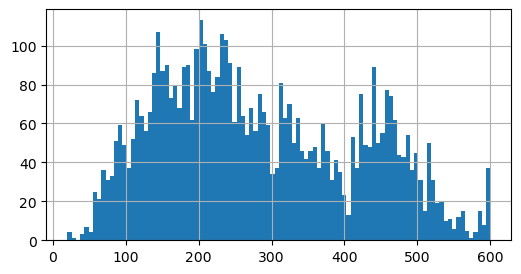

In [17]:
length_list = []
for sample in tokenized_train['input_ids']:
    for option in sample:
        length_list.append(len(option))

plt.figure(figsize=[6,3])
pd.Series(length_list).hist(bins=100)

In [18]:
test_dataset = Dataset.from_pandas(test_p.to_pandas())
tokenized_test = test_dataset.map(preprocess, remove_columns=['question', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['passage_id', 'section_text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})

## Train DeBERTa

In [19]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [20]:
#AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)

In [21]:
retrain = True

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    learning_rate=5e-6,
    num_train_epochs=6,
    #fp16=True,
    warmup_ratio=0.5,
    weight_decay=0.002,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=16,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=100,
    eval_steps=500,
    save_steps=5000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='Train with Colbert'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    
    # embedding_lr = 1e-8
    # early_layers_lr = 1e-7
    # middle_layers_lr = 1e-6
    # late_layers_lr = 2e-5
    # classifier_lr = 5e-5

#     optimizer_grouped_parameters = [
#         {'params': model.deberta.embeddings.parameters(), 'lr': embedding_lr},
#         {'params': model.deberta.encoder.layer[:8].parameters(), 'lr': early_layers_lr},
#         {'params': model.deberta.encoder.layer[8:16].parameters(), 'lr': middle_layers_lr},
#         {'params': model.deberta.encoder.layer[16:].parameters(), 'lr': late_layers_lr},
#         {'params': model.classifier.parameters(), 'lr': classifier_lr},
#     ]
    optimizer = AdamW(model.parameters(),
                      lr=training_args.learning_rate,
                      weight_decay=training_args.weight_decay)
                      #optimizer_grouped_parameters)
    
    total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
    warmup_steps = int(total_steps * training_args.warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )
    

    trainer.train()
    wandb.finish()
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/'checkpoint-19500')

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datadan. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Map At 3
500,1.602100,1.608639,0.355000,0.478000
1000,1.200300,1.308999,0.535000,0.643000
1500,0.801000,1.115933,0.630000,0.722000
2000,0.954400,0.948591,0.690000,0.788000
2500,0.556300,0.963374,0.720000,0.812000
3000,0.558700,1.072957,0.695000,0.798000
3500,0.302500,0.890864,0.695000,0.804000
4000,0.443600,0.962828,0.700000,0.794000
4500,0.184500,0.911541,0.685000,0.790000
5000,0.162900,1.030687,0.710000,0.808000


/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▄▆▇█▇▇█▇███
eval/loss,█▅▃▂▂▃▁▂▁▂▃▂
eval/map_at_3,▁▄▆▇████████
eval/runtime,█▂▂▂▂▁▂▂▁▂▁▂
eval/samples_per_second,▁▇▇▇▇█▇▇█▇█▇
eval/steps_per_second,▁▆▇▆▆█▇▇▇▇▇▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇████▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
train/loss,██████▆▄▅▅▅▆▅▅▃▃▃▃▂▄▂▂▂▂▂▂▃▂▁▁▂▂▂▂▁▁▁▁▁▁
train/total_flos,▁
